# Orders - Multivariate Regression of review_score

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# import modules 
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
''' You can download the solution for yesterday's optional distance_seller_customer function from Kitt 
and paste it into your olist/orders.py file, if you weren't able to complete it '''
# import orders dataset
from olist.order import Order
orders = Order().get_training_data(with_distance_seller_customer=True)

In [5]:
# I still need to understand tables 
# so I will import data.py to see matching tables
# Import olist data
from olist.data import Olist
olist=Olist()
data=olist.get_data()  ## is dict
matching_table = olist.get_matching_table()
list(data.keys())

['sellers',
 'product_category_name_translation',
 'orders',
 'order_items',
 'customers',
 'geolocation',
 'order_payments',
 'order_reviews',
 'products']

In [6]:
type(list( data.values() )[0] ) ## sellers

pandas.core.frame.DataFrame

In [7]:
list( data.values() )[0] .head(1)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP


In [8]:
print(matching_table.shape) # we merge 
#orders = data["orders"][["customer_id", "order_id"]]
#reviews = data["order_reviews"][["order_id", "review_id"]]
#items = data["order_items"][["order_id", "product_id", "seller_id"]]
# on="order_id", how="outer"

matching_table.head(2)

(114100, 5)


,customer_id,order_id,review_id,product_id,seller_id
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,a54f0611adc9ed256b57ede6b6eb5114,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9
1,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,8d5266042046a06655c8db133d120ba5,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962


In [9]:
# import orders dataset
#from olist.order import Order
#orders = Order().get_training_data(with_distance_seller_customer=True)
print(orders.shape)
orders.head(2)

(96525, 13)


,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,e481f51cbdc54678b7cc49136f2d6af7,8.436574,15.544063,0.0,delivered,0,0,4,1,1,29.99,8.72,18.063837
1,53cdb2fc8bc7dce0b6741e2150273451,13.782037,19.137766,0.0,delivered,0,0,4,1,1,118.70,22.76,856.292580


In [10]:
#orders = Order().get_training_data(with_distance_seller_customer=True)

    #        self.get_wait_time(is_delivered)\
   #             .merge(
   #             self.get_review_score(), on='order_id'
   #            ).merge(
  #              self.get_number_products(), on='order_id'
  #             ).merge(
     #           self.get_number_sellers(), on='order_id'
        #       ).merge(
  #              self.get_price_and_freight(), on='order_id'
    #           )
        # Skip heavy computation of distance_seller_customer unless specified
    #    if with_distance_seller_customer:
  #          training_set = training_set.merge(
    #            self.get_distance_seller_customer(), on='order_id')


In [11]:
print(len(orders.columns))
orders.columns

13


Index(['order_id', 'wait_time', 'expected_wait_time', 'delay_vs_expected',
       'order_status', 'dim_is_five_star', 'dim_is_one_star', 'review_score',
       'number_of_products', 'number_of_sellers', 'price', 'freight_value',
       'distance_seller_customer'],
      dtype='object')

In [12]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96525 entries, 0 to 96532
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   order_id                  96525 non-null  object 
 1   wait_time                 96525 non-null  float64
 2   expected_wait_time        96525 non-null  float64
 3   delay_vs_expected         96525 non-null  float64
 4   order_status              96525 non-null  object 
 5   dim_is_five_star          96525 non-null  int64  
 6   dim_is_one_star           96525 non-null  int64  
 7   review_score              96525 non-null  int64  
 8   number_of_products        96525 non-null  int64  
 9   number_of_sellers         96525 non-null  int64  
 10  price                     96525 non-null  float64
 11  freight_value             96525 non-null  float64
 12  distance_seller_customer  96525 non-null  float64
dtypes: float64(6), int64(5), object(2)
memory usage: 10.3+ MB


Let's recall our simple analysis from yesterday's exercise: 

Based on our correlation matrix below, we notice that `review_score` is mostly correlated with the two features `wait_time` and `delay_vs_expected`. However, these two features are also highly correlated with each other. In this exercise, we will use `statsmodels` to distinguish the effect of one feature, **holding the other one constant**.

<AxesSubplot:>

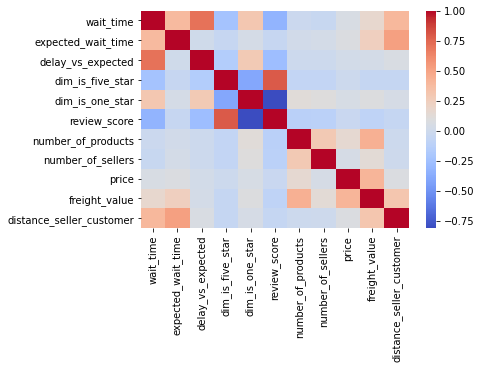

In [13]:
sns.heatmap(orders.corr(), cmap='coolwarm')

(0.0, 5.932101750136774)

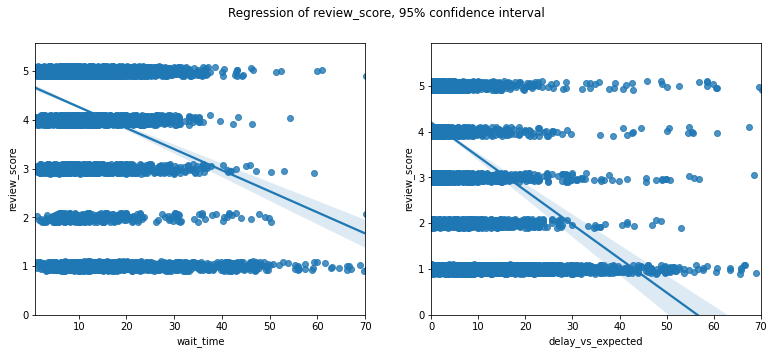

In [14]:
sample = orders.sample(10000, random_state=42)
plt.figure(figsize=(13,5))
plt.suptitle('Regression of review_score, 95% confidence interval')
plt.subplot(1,2,1)
sns.regplot(x = sample.wait_time, y= sample.review_score, y_jitter=.1, ci=95)
plt.xlim(right=70)
plt.ylim(bottom=0)

plt.subplot(1,2,2)
sns.regplot(x = orders.delay_vs_expected, y= orders.review_score, y_jitter=.1, ci=95)
plt.xlim(right=70)
plt.ylim(bottom=0)

## 1 - Univariate regression

❓Use [statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.formula.api.ols.html) with `statsmodels.formula.api` to quickly make
 - `model1`: an ols regression of `review_score` over `wait_time`
 - `model2`: an ols regression of `review_score` over `delay_vs_expected`

For each, Print the `summary` table and interpret the results:
- Make sure to understand how these results match those of the seaborn regplot
- Read the regression performance metric R-squared, as well as individual regression coefficients, t-values, p-values, and 95% confidence intervals

In [15]:
import statsmodels.formula.api as smf

In [16]:
# YOUR CODE HERE
model1 = smf.ols(" review_score ~ wait_time", data=orders).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                 1.221e+04
Date:                Wed, 21 Jul 2021   Prob (F-statistic):               0.00
Time:                        23:24:50   Log-Likelihood:            -1.5630e+05
No. Observations:               96525   AIC:                         3.126e+05
Df Residuals:                   96523   BIC:                         3.126e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7138      0.006    725.216      0.0

In [17]:
# YOUR CODE HERE
model2 = smf.ols(" review_score ~ delay_vs_expected", data=orders).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     7710.
Date:                Wed, 21 Jul 2021   Prob (F-statistic):               0.00
Time:                        23:24:50   Log-Likelihood:            -1.5834e+05
No. Observations:               96525   AIC:                         3.167e+05
Df Residuals:                   96523   BIC:                         3.167e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.1994      0.00

In [18]:
from scipy.stats import pearsonr

# Correlación lineal entre las dos variables
# ==============================================================================
corr_test = pearsonr(x = orders['wait_time'], y =  orders['delay_vs_expected'])
print("Coeficiente de correlación de Pearson: ", corr_test[0])
print("P-value: ", corr_test[1])


Coeficiente de correlación de Pearson:  0.7073287841106308
P-value:  0.0


## 2 - Multivariate regression

❓ What is the impact on `review_score` of adding one day of `delay_vs_expected` to the order, **holding `wait_time` constant**? Which of the two features is the most explicative for the low `review_score`?

For that purpose, run an OLS model `model3` where both `wait_time` and `delay_vs_expected` are the features (independent variables), and `review_score` is the target (dependent variable)

In [19]:
import statsmodels.api as sm

In [20]:
# YOUR CODE HERE
model3 = smf.ols(" review_score ~ wait_time + delay_vs_expected", data=orders).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     6254.
Date:                Wed, 21 Jul 2021   Prob (F-statistic):               0.00
Time:                        23:24:52   Log-Likelihood:            -1.5616e+05
No. Observations:               96525   AIC:                         3.123e+05
Df Residuals:                   96522   BIC:                         3.124e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.6442      0.00

$R^2$ is basically how well the model explains the data.
A value of 1.0 means that the variance in the y-values are 100% explained by the X-values.
A negative 𝑅² value means that using the average value of y is a better predictor than the regression model.
𝑅² is also just the square term of the correlation coefficient 𝑅.


model1  : $R^2 = 0.112$
model2  : $R^2 = 0.074$
model3  : $R^2 = 0.1147$

In [21]:
model3.rsquared

0.11472466333201459

In [22]:
model3.summary2().tables[1]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,4.644161,0.007768,597.864824,0.000000e+00,4.628936,4.659386
wait_time,-0.038820,0.000582,-66.663369,0.000000e+00,-0.039961,-0.037678
delay_vs_expected,-0.019103,0.001170,-16.327063,7.624532e-60,-0.021396,-0.016809


The Coef. column represent the value of the Beta Coefficients. 

----
❓Our multivariate regression allows us to isolate the impact of one feature, while controlling the effect of other features. These new coefficients are called **partial correlation** coefficients. Can you notice the difference with the **simple regression** coeffients computed with seaborn above? What can you say about the relative slopes for `wait_time` and `delay_vs_expected`? 


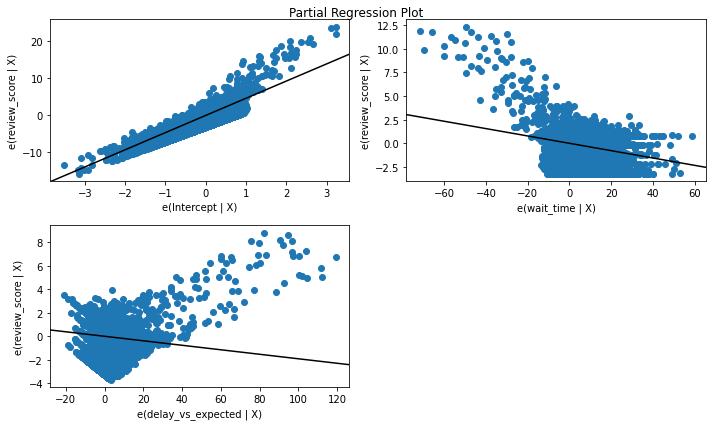

In [44]:
fig = plt.figure(figsize=(10,6))
fig = sm.graphics.plot_partregress_grid(model3, fig=fig)

<details>
    <summary>💡 Solution</summary>

- Holding `wait_time` constant, each additional day of `delay` reduces the review_score on average by 0.0191 [0.017 - 0.21] points
- Holding `delay` constant, each additional day of `wait_time` reduces the review_score on average by 0.0388 points 

Contrary to what was found with the simple bivariate correlation analysis, `delay` is actually less impactful than `wait_time` in driving lower `review_score`! This interesting finding demonstrates the importance of multi-variate regression to remove the potential impact of confounding factors

---
❓ R-squared is quite low: no more than 12% of the variation of review_score is explained by the combined variations of `wait_time` and `delay_vs_expected`. Let's try to add more features to our regression to improve explainability.

- Create a new OLS `model4` with more features from `orders` dataset.
    - Do not create **data leaks**: do not add features that are directly derived from the `review_score`
    - Do not add two features perfectly colinear with each other
    - Transform each feature $X_i$ into its respective z-score $Z_i = \frac{X_i - \mu_i}{\sigma_i}$ in order to compare the partial regression coefficients $\beta_i$ together. Otherwise, the $\beta_i$ are not of the same dimension, meaning you'll be comparing apples (e.g. "review_stars per day") with oranges (e.g. "review_stars per BRL")!

In [95]:
print(len(list(orders.columns)) - 3  ) # there are 2 categorical var ; the 3th var is dependent 
list(orders.columns)

10


['order_id',
 'wait_time',
 'expected_wait_time',
 'delay_vs_expected',
 'order_status',
 'dim_is_five_star',
 'dim_is_one_star',
 'review_score',
 'number_of_products',
 'number_of_sellers',
 'price',
 'freight_value',
 'distance_seller_customer']

In [23]:
# Select features
# YOUR CODE HERE
model4 = smf.ols(
" review_score ~ wait_time \
+ delay_vs_expected + expected_wait_time \
+ freight_value + price ",
                 data=orders).fit()
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     2689.
Date:                Wed, 21 Jul 2021   Prob (F-statistic):               0.00
Time:                        23:25:01   Log-Likelihood:            -1.5575e+05
No. Observations:               96525   AIC:                         3.115e+05
Df Residuals:                   96519   BIC:                         3.116e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.4830      0

In [24]:
# Select features
# YOUR CODE HERE
model4 = smf.ols(
" review_score ~ wait_time \
+ delay_vs_expected  \
+ freight_value + price \
 + number_of_sellers + number_of_products \
+ distance_seller_customer",
                 data=orders).fit()
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     2348.
Date:                Wed, 21 Jul 2021   Prob (F-statistic):               0.00
Time:                        23:25:15   Log-Likelihood:            -1.5446e+05
No. Observations:               96525   AIC:                         3.089e+05
Df Residuals:                   96517   BIC:                         3.090e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [97]:
print(smf.ols(" price ~ freight_value", data=orders).fit().rsquared)
print(smf.ols(" price ~ distance_seller_customer", data=orders).fit().rsquared)

0.16941461412688674
0.006352854475605851


In [25]:
features = ['wait_time',
 'delay_vs_expected',
 'number_of_sellers', 'number_of_products',
 'price',
 'freight_value',
 'distance_seller_customer']

#### z-score

In [35]:
orders = Order().get_training_data(with_distance_seller_customer=True)
orders.head(1)

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,e481f51cbdc54678b7cc49136f2d6af7,8.436574,15.544063,0.0,delivered,0,0,4,1,1,29.99,8.72,18.063837


In [36]:
# standardize features (transform them into their respective z-scores)
orders_standardized = orders.copy()

for i in features:
    m = orders_standardized[i].mean()
    sigma = orders_standardized[i].std()
    z = (np.asarray(orders_standardized[i]) - m ) / sigma 
    orders_standardized[i] = list(z)

In [37]:
orders_standardized.head(1)

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,e481f51cbdc54678b7cc49136f2d6af7,-0.431707,15.544063,-0.162787,delivered,0,0,4,-0.264004,-0.112813,-0.51186,-0.651997,-0.979467


In [38]:
print(orders_standardized['wait_time'].mean(), orders_standardized['wait_time'].std() )

2.7606562464678058e-14 1.0000000000000058


In [39]:
orders_standardized.describe()

,wait_time,expected_wait_time,delay_vs_expected,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
count,9.652500e+04,96525.000000,9.652500e+04,96525.000000,96525.000000,96525.000000,9.652500e+04,9.652500e+04,9.652500e+04,9.652500e+04,9.652500e+04
mean,2.760656e-14,23.744247,-5.189734e-15,0.588977,0.100596,4.142005,1.572914e-15,-3.933399e-17,-5.767696e-13,-7.981980e-14,4.492304e-16
std,1.000000e+00,8.769554,1.000000e+00,0.492022,0.300794,1.296748,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.260090e+00,2.008009,-1.627873e-01,0.000000,0.000000,1.000000,-2.640036e-01,-1.128127e-01,-6.513292e-01,-1.056565e+00,-1.009815e+00
25%,-6.069959e-01,18.330069,-1.627873e-01,0.000000,0.000000,4.000000,-2.640036e-01,-1.128127e-01,-4.357119e-01,-4.149156e-01,-6.950415e-01
50%,-2.451963e-01,23.232187,-1.627873e-01,1.000000,0.000000,5.000000,-2.640036e-01,-1.128127e-01,-2.437862e-01,-2.604185e-01,-2.805496e-01
75%,3.316656e-01,28.417963,-1.627873e-01,1.000000,0.000000,5.000000,-2.640036e-01,-1.128127e-01,6.205053e-02,5.692679e-02,3.306386e-01
max,2.065658e+01,155.135463,3.963476e+01,1.000000,1.000000,5.000000,3.673751e+01,3.219949e+01,6.367082e+01,8.222152e+01,1.366879e+01


In [40]:
# Create and train model4
model4 = smf.ols(
" review_score ~ wait_time \
+ delay_vs_expected  \
+ freight_value + price \
 + number_of_sellers + number_of_products \
+ distance_seller_customer",
                 data=orders_standardized).fit()
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     2348.
Date:                Wed, 21 Jul 2021   Prob (F-statistic):               0.00
Time:                        23:29:59   Log-Likelihood:            -1.5446e+05
No. Observations:               96525   AIC:                         3.089e+05
Df Residuals:                   96517   BIC:                         3.090e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

---
❓ What are the most important features? (make a bar chart to visualize them well)
- How has the overall regression performance changed?
- Is this regression statistically significant?

<AxesSubplot:>

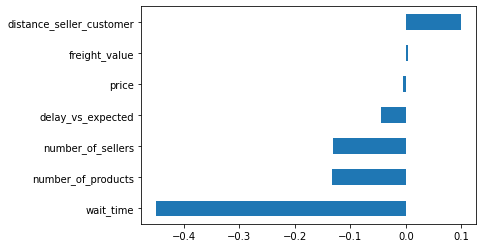

In [32]:
model4.params[1:].sort_values().plot(kind='barh')

In [5]:
# Your answer

<details>
    <summary>💡Explanations</summary>
    

- `wait_time` is the biggest explanatory variable
- The more `products` and `sellers` there are for a single order, the lower the `review_score`. 
- Distance also plays a role.
- Depending on your choice of feature, you may not be able to conclude anything about `price` and `freight_value` if their p-values are too high
    
- Overall, this multivariate regression remains statistically significant, because its F-statistics are much greater than 1 (at least one feature has a very low p-value)

- R-squared hasn't increased by much. Most of the explanability of review_score lies outside of the orders dataset.

Low R-squared is common when the number of observations (n) is much higher than the number of features (p). Relevant insights can still be derived from such regressions, provided they are statistically significant
</details>



## 3 - Check model performance

Regression performance should not be measured only by it's R-squared!  
Always visualize the distribution of the predictions, and especially the residuals.

❓ Compute the residuals, notice how their mean is equal to 0 (always the case in linear regression), and compute the associated RMSE.   
Plot the `residuals` in a histogram.

In [33]:
#estimated coefficients
print(model4.params)
n = model4.resid
print(n) # estim_residuals

Intercept                   4.142005
wait_time                  -0.450029
delay_vs_expected          -0.044982
freight_value               0.004872
price                      -0.004405
number_of_sellers          -0.131830
number_of_products         -0.132475
distance_seller_customer    0.098776
dtype: float64
0       -0.295784
1       -0.184043
2        0.667432
3        0.625966
4        0.439598
           ...   
96528    0.685274
96529    0.277952
96530    1.312224
96531   -1.710528
96532    0.565040
Length: 96525, dtype: float64


In [41]:
# Your code
predicted_review_score = model4.predict(orders_standardized[features])
residuals = predicted_review_score - orders_standardized.review_score

In [42]:
RMSE = (residuals.map(lambda x: x**2).sum() / len(residuals))**0.5
RMSE

1.1986853369569426

Text(0.5, 1.0, 'residuals density plot')

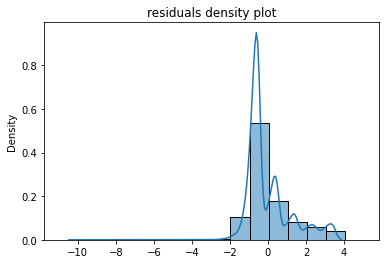

In [43]:
sns.histplot(residuals, kde=True, stat='density', discrete=True)
plt.title('residuals density plot')

Text(0.5, 1.0, 'distribution of predicted and actual values')

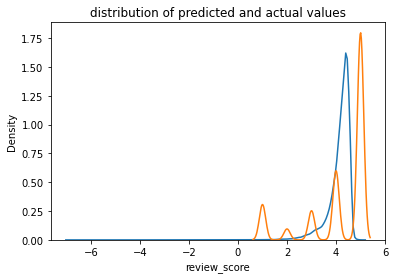

In [44]:
# Your code here
sns.kdeplot(predicted_review_score, label='predicted review score')
sns.kdeplot(orders.review_score, label = 'actual review score')
plt.title('distribution of predicted and actual values')

In [45]:
# my code
residuals = model4.predict(orders_standardized[features]) - orders_standardized['review_score']
print(len(residuals))
print(residuals)
#residuals.std()/orders.wait_time.std() * 1/(n**0.5)

96525
0        0.295784
1        0.184043
2       -0.667432
3       -0.625966
4       -0.439598
           ...   
96528   -0.685274
96529   -0.277952
96530   -1.312224
96531    1.710528
96532   -0.565040
Length: 96525, dtype: float64


Text(0.5, 1.0, 'residuals density plot')

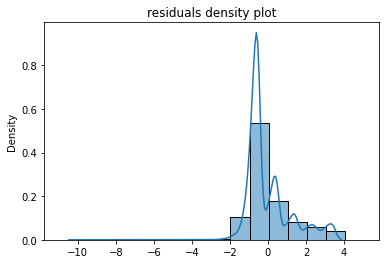

In [46]:
sns.histplot(residuals, kde=True, stat='density', discrete=True)
plt.title('residuals density plot')

In [55]:
residuals.std()/std_features * 1/(n**0.5)

0                    NaN
1                    NaN
2                    NaN
3                    NaN
4                    NaN
                      ..
expected_wait_time   NaN
freight_value        NaN
number_of_sellers    NaN
price                NaN
wait_time            NaN
Length: 96532, dtype: float64

❓ Can you guess why the residual distplot is such a strange shape? To understand, plot on the same axis the histogram of `review_score` as well as that of the `predicted_review_score` for each row of the dataset

In [7]:
# Your code

<details>
    <summary>💡Explanations</summary>

☝️ Our model is not so great, for two reasons
- First, because we don't have enough features to explain a significant proportion of the review_scores (low R-squared)
- Secondly, because we are trying to fit a "linear regression" function to a discreet classification problem

Tomorrow, you will discover a new model: the logistic regression classifier
    
</details>

🏁 Great job! Don't forget to *save*, *commit* and *push* this notebook when you are done